In [ ]:
# https://drive.google.com/file/d/1ugszR_wG8B04HRzk5_wqWB-uHoxNbgfd/view?usp=sharing - google drive link
# Download the file using gdown
!gdown --id 1ugszR_wG8B04HRzk5_wqWB-uHoxNbgfd

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ugszR_wG8B04HRzk5_wqWB-uHoxNbgfd
From (redirected): https://drive.google.com/uc?id=1ugszR_wG8B04HRzk5_wqWB-uHoxNbgfd&confirm=t&uuid=f2781f50-4952-4dfb-9261-df4f719f15c2
To: /content/validation_depth_8bit_3ch.zip
100% 103M/103M [00:00<00:00, 212MB/s] 


In [2]:
!unzip validation_depth_8bit_3ch.zip

Streaming output truncated to the last 5000 lines.
  inflating: validation_depth_8bit_3ch/tomato/tomato_6_2_226_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_6_2_226_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_8_1_226_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_8_1_226_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_8_1_231_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_8_1_231_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_2_1_201_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_2_1_201_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_8_2_6_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomato/._tomato_8_2_6_depthcrop.png  
  inflating: validation_depth_8bit_3ch/tomato/tomato_2_1_1_depthcrop.png  
  inflating: __MACOSX/validation_depth_8bit_3ch/tomat

In [3]:
!pip install torchvision tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 130.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 3. Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406],  # imagenet mean and std
    #                      std=[0.229, 0.224, 0.225])
    transforms.Normalize(mean=[0.3762, 0.3762, 0.3762],  # our dataset mean/std
                         std=[0.2760, 0.2760, 0.2760])
])


val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=[0.3762, 0.3762, 0.3762],
                         std=[0.2760, 0.2760, 0.2760])
])

In [6]:
# 4. Load dataset and split indices
data_dir = 'validation_depth_8bit_3ch'
full_dataset = datasets.ImageFolder(root=data_dir)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

# Get shuffled indices for reproducibility
indices = list(range(len(full_dataset)))
random.shuffle(indices)
train_indices = indices[:train_size]
val_indices = indices[train_size:]

#5. Split using Subset
train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

# 6. Assign transforms afterwards
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [15]:
# Print dimensions of a few images from the training set
print("\nTraining set image dimensions:")
for images, labels in train_loader:
    for i, img in enumerate(images[:2]):  # Print dimensions of the first 2 images
        print(f"Image {i + 1} dimensions: {img.shape}")
    break  # Exit after processing the first batch

# Print dimensions of a few images from the validation set
print("\nValidation set image dimensions:")
for images, labels in val_loader:
    for i, img in enumerate(images[:2]):  # Print dimensions of the first 2 images
        print(f"Image {i + 1} dimensions: {img.shape}")
    break  # Exit after processing the first batch

    # Get size of train and validation sets
train_size = len(train_dataset)
val_size = len(val_dataset)

print(f"Training set size: {train_size:,}")
print(f"Validation set size: {val_size:,}")


Training set image dimensions:
Image 1 dimensions: torch.Size([3, 299, 299])
Image 2 dimensions: torch.Size([3, 299, 299])

Validation set image dimensions:
Image 1 dimensions: torch.Size([3, 299, 299])
Image 2 dimensions: torch.Size([3, 299, 299])
Training set size: 33,501
Validation set size: 8,376


In [ ]:
import torch.nn as nn
from torchvision import models

# Load a pretrained AlexNet model
weights = models.AlexNet_Weights.DEFAULT
model = models.alexnet(weights=weights)

# Freeze all feature extractor layers
for param in model.features.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

# Replace the classifier
# The original AlexNet classifier has input features = 9216
model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(9216, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(p=0.4),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(p=0.4),
    nn.Linear(128, 51)  # Final output layer for 51 classes
)

# Move the model to the device (GPU or CPU)
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=512, bias=True)
  

In [17]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 7,262,323
Trainable parameters: 4,792,627
Frozen parameters: 2,469,696


In [18]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

optimizer = Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,
    weight_decay=1e-4  # L2 regularization
)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='max', patience=3, factor=0.5)

In [19]:
num_epochs = 20

train_loss_list = []
val_loss_list = []
train_top1_list = []
train_top5_list = []
val_top1_list = []
val_top5_list = []

best_val_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total_train = 0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

        # Top-1
        _, predicted = torch.max(outputs.data, 1)
        correct_top1 += (predicted == labels).sum().item()

        # Top-5
        top5_preds = torch.topk(outputs, 5, dim=1).indices
        correct_top5 += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

        total_train += labels.size(0)

    train_top1_acc = correct_top1 / total_train * 100
    train_top5_acc = correct_top5 / total_train * 100
    avg_train_loss = train_loss / total_train

    train_loss_list.append(avg_train_loss)
    train_top1_list.append(train_top1_acc)
    train_top5_list.append(train_top5_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_top1 = 0
    correct_top5 = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)

            # Top-1
            _, predicted = torch.max(outputs.data, 1)
            correct_top1 += (predicted == labels).sum().item()

            # Top-5
            top5_preds = torch.topk(outputs, 5, dim=1).indices
            correct_top5 += sum([labels[i] in top5_preds[i] for i in range(labels.size(0))])

            total_val += labels.size(0)

    val_top1_acc = correct_top1 / total_val * 100
    val_top5_acc = correct_top5 / total_val * 100
    avg_val_loss = val_loss / total_val

    val_loss_list.append(avg_val_loss)
    val_top1_list.append(val_top1_acc)
    val_top5_list.append(val_top5_acc)

    # Scheduler step
    scheduler.step(val_top1_acc)

    print(f"Epoch {epoch + 1}")
    print(f"Top-1 Train Accuracy: {train_top1_acc:.2f}% --- Train Loss: {avg_train_loss:.4f}  |  Top-5 Train Accuracy: {train_top5_acc:.2f}%")
    print(f"Top-1 Val Accuracy:   {val_top1_acc:.2f}% --- Val Loss:   {avg_val_loss:.4f}  |  Top-5 Val Accuracy:   {val_top5_acc:.2f}%\n")

    # Save best model
    if val_top1_acc > best_val_accuracy:
        best_val_accuracy = val_top1_acc
        torch.save(model.state_dict(), 'best_model.pth')

print("Training Complete!")

Epoch 1
Top-1 Train Accuracy: 32.65% --- Train Loss: 2.7564  |  Top-5 Train Accuracy: 61.33%
Top-1 Val Accuracy:   57.53% --- Val Loss:   1.8490  |  Top-5 Val Accuracy:   88.43%



Epoch 2
Top-1 Train Accuracy: 52.71% --- Train Loss: 1.8571  |  Top-5 Train Accuracy: 84.07%
Top-1 Val Accuracy:   68.52% --- Val Loss:   1.3407  |  Top-5 Val Accuracy:   93.10%



Epoch 3
Top-1 Train Accuracy: 61.97% --- Train Loss: 1.4678  |  Top-5 Train Accuracy: 89.53%
Top-1 Val Accuracy:   73.73% --- Val Loss:   1.0743  |  Top-5 Val Accuracy:   95.20%



Epoch 4
Top-1 Train Accuracy: 66.61% --- Train Loss: 1.2418  |  Top-5 Train Accuracy: 92.08%
Top-1 Val Accuracy:   76.85% --- Val Loss:   0.8882  |  Top-5 Val Accuracy:   96.37%



Epoch 5
Top-1 Train Accuracy: 69.90% --- Train Loss: 1.0834  |  Top-5 Train Accuracy: 93.79%
Top-1 Val Accuracy:   78.96% --- Val Loss:   0.7682  |  Top-5 Val Accuracy:   96.85%



Epoch 6
Top-1 Train Accuracy: 72.69% --- Train Loss: 0.9739  |  Top-5 Train Accuracy: 94.80%
Top-1 Val Accuracy:   80.60% --- Val Loss:   0.6911  |  Top-5 Val Accuracy:   97.34%



Epoch 7
Top-1 Train Accuracy: 74.57% --- Train Loss: 0.8871  |  Top-5 Train Accuracy: 95.24%
Top-1 Val Accuracy:   81.75% --- Val Loss:   0.6335  |  Top-5 Val Accuracy:   97.73%



Epoch 8
Top-1 Train Accuracy: 75.82% --- Train Loss: 0.8279  |  Top-5 Train Accuracy: 95.80%
Top-1 Val Accuracy:   82.45% --- Val Loss:   0.5901  |  Top-5 Val Accuracy:   97.92%



Epoch 9
Top-1 Train Accuracy: 77.09% --- Train Loss: 0.7755  |  Top-5 Train Accuracy: 96.33%
Top-1 Val Accuracy:   83.35% --- Val Loss:   0.5567  |  Top-5 Val Accuracy:   98.07%



Epoch 10
Top-1 Train Accuracy: 77.98% --- Train Loss: 0.7341  |  Top-5 Train Accuracy: 96.57%
Top-1 Val Accuracy:   84.24% --- Val Loss:   0.5268  |  Top-5 Val Accuracy:   98.27%



Epoch 11
Top-1 Train Accuracy: 79.10% --- Train Loss: 0.6964  |  Top-5 Train Accuracy: 96.93%
Top-1 Val Accuracy:   84.72% --- Val Loss:   0.5088  |  Top-5 Val Accuracy:   98.30%



Epoch 12
Top-1 Train Accuracy: 79.82% --- Train Loss: 0.6693  |  Top-5 Train Accuracy: 97.08%
Top-1 Val Accuracy:   85.04% --- Val Loss:   0.4856  |  Top-5 Val Accuracy:   98.35%



Epoch 13
Top-1 Train Accuracy: 80.00% --- Train Loss: 0.6477  |  Top-5 Train Accuracy: 97.15%
Top-1 Val Accuracy:   85.39% --- Val Loss:   0.4710  |  Top-5 Val Accuracy:   98.39%



Epoch 14
Top-1 Train Accuracy: 80.73% --- Train Loss: 0.6212  |  Top-5 Train Accuracy: 97.48%
Top-1 Val Accuracy:   85.85% --- Val Loss:   0.4550  |  Top-5 Val Accuracy:   98.52%



Epoch 15
Top-1 Train Accuracy: 81.28% --- Train Loss: 0.5993  |  Top-5 Train Accuracy: 97.64%
Top-1 Val Accuracy:   86.21% --- Val Loss:   0.4455  |  Top-5 Val Accuracy:   98.73%



Epoch 16
Top-1 Train Accuracy: 82.07% --- Train Loss: 0.5815  |  Top-5 Train Accuracy: 97.71%
Top-1 Val Accuracy:   86.47% --- Val Loss:   0.4278  |  Top-5 Val Accuracy:   98.66%



Epoch 17
Top-1 Train Accuracy: 82.11% --- Train Loss: 0.5690  |  Top-5 Train Accuracy: 97.72%
Top-1 Val Accuracy:   86.43% --- Val Loss:   0.4247  |  Top-5 Val Accuracy:   98.59%



Epoch 18
Top-1 Train Accuracy: 82.65% --- Train Loss: 0.5508  |  Top-5 Train Accuracy: 97.93%
Top-1 Val Accuracy:   86.76% --- Val Loss:   0.4148  |  Top-5 Val Accuracy:   98.83%



Epoch 19
Top-1 Train Accuracy: 82.91% --- Train Loss: 0.5422  |  Top-5 Train Accuracy: 97.91%
Top-1 Val Accuracy:   87.13% --- Val Loss:   0.4067  |  Top-5 Val Accuracy:   98.89%



Epoch 20
Top-1 Train Accuracy: 83.32% --- Train Loss: 0.5256  |  Top-5 Train Accuracy: 98.10%
Top-1 Val Accuracy:   87.51% --- Val Loss:   0.3997  |  Top-5 Val Accuracy:   98.79%

Training Complete!


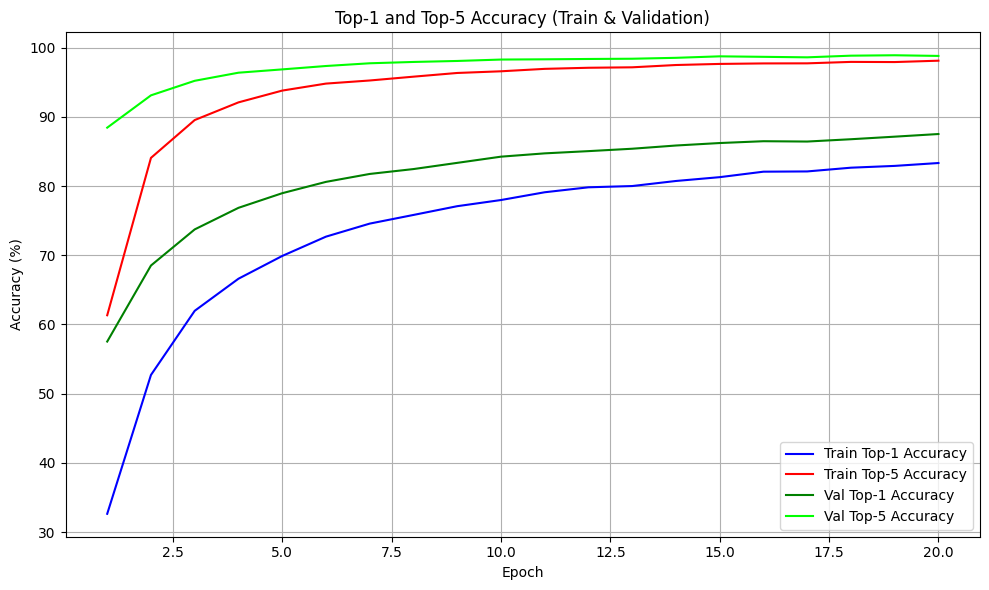

In [22]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_top1_list, label='Train Top-1 Accuracy', color='blue')
plt.plot(epochs, train_top5_list, label='Train Top-5 Accuracy', color='red')
plt.plot(epochs, val_top1_list, label='Val Top-1 Accuracy', color='green')
plt.plot(epochs, val_top5_list, label='Val Top-5 Accuracy', color='lime')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Top-1 and Top-5 Accuracy (Train & Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

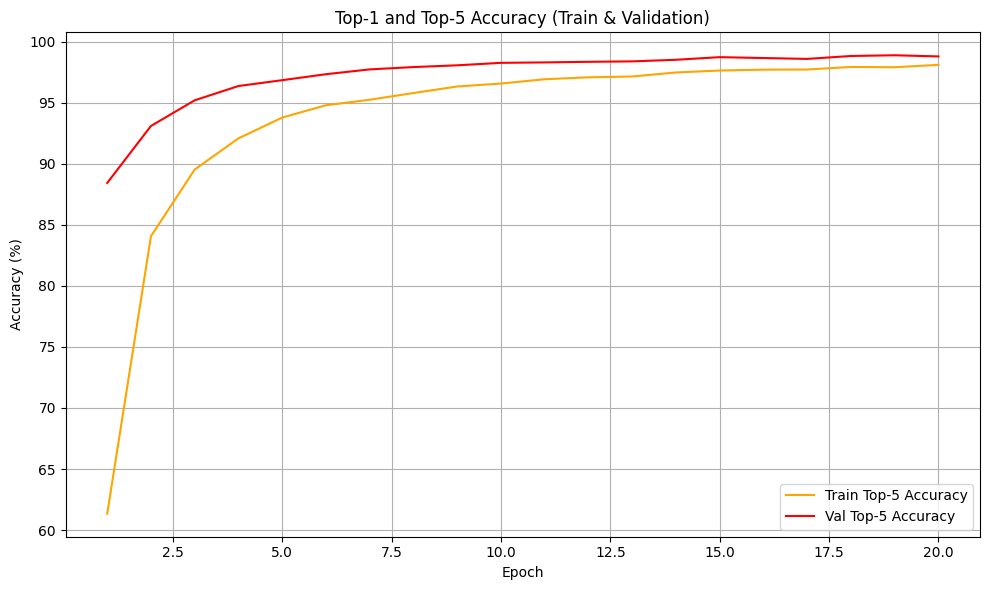

In [23]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
# plt.plot(epochs, train_top1_list, label='Train Top-1 Accuracy', color='blue')
plt.plot(epochs, train_top5_list, label='Train Top-5 Accuracy', color='orange')
# plt.plot(epochs, val_top1_list, label='Val Top-1 Accuracy', color='green')
plt.plot(epochs, val_top5_list, label='Val Top-5 Accuracy', color='red')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Top-1 and Top-5 Accuracy (Train & Validation)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()